# 📚 Vietnamese Text Summarization với mT5, ViT5

## Tổng quan dự án

**Mục tiêu**: Fine-tune models transformer cho tóm tắt văn bản tiếng Việt  
**Dataset**: VLSP 2021 Summarization Task  
**Models**: PhoBERT (extractive), mT5 (abstractive), ViT5 (abstractive)

---

## 📋 Nội dung

1. **Lý thuyết Text Summarization**
2. **Setup Environment & Load Data**
3. **Data Preprocessing & EDA**
4. **Model Implementation**
   - PhoBERT (Extractive)
   - mT5 (Abstractive)
   - ViT5 (Abstractive)
5. **Training & Fine-tuning**
6. **Evaluation với ROUGE metrics**
7. **Model Comparison & Analysis**

---

## 1️⃣ LÝ THUYẾT TEXT SUMMARIZATION

### A. Hai loại Text Summarization

#### **Extractive Summarization** (PhoBERT)

```
Input: "Việt Nam là một đất nước đông dân. Nền kinh tế phát triển nhanh. 
        Văn hóa đa dạng và phong phú."

Extractive: "Việt Nam là một đất nước đông dân. Nền kinh tế phát triển nhanh."
             ↑ Chọn câu quan trọng từ văn bản gốc
```

**Cách hoạt động:**
- Chấm điểm từng câu trong văn bản (sentence scoring)
- Chọn top-k câu có điểm cao nhất
- Sắp xếp lại theo thứ tự xuất hiện

**Ưu điểm:**
- ✅ Đảm bảo ngữ pháp chính xác (vì dùng câu gốc)
- ✅ Không tạo thông tin sai (no hallucination)
- ✅ Training nhanh, ít resource

**Nhược điểm:**
- ❌ Thiếu tính linh hoạt
- ❌ Có thể không mạch lạc
- ❌ Không thể paraphrase

---

#### **Abstractive Summarization** (mT5, ViT5)

```
Input: "Việt Nam là một đất nước đông dân. Nền kinh tế phát triển nhanh. 
        Văn hóa đa dạng và phong phú."

Abstractive: "Việt Nam có dân số đông với nền kinh tế và văn hóa phát triển."
              ↑ Tạo câu mới, tổng hợp thông tin
```

**Cách hoạt động:**
- Encoder đọc và hiểu văn bản
- Decoder sinh ra văn bản tóm tắt từng token
- Attention mechanism tập trung vào phần quan trọng

**Ưu điểm:**
- ✅ Tóm tắt tự nhiên, mạch lạc
- ✅ Có thể paraphrase và tổng hợp
- ✅ Linh hoạt về độ dài

**Nhược điểm:**
- ❌ Có thể tạo thông tin sai (hallucination)
- ❌ Cần nhiều tài nguyên training
- ❌ Phức tạp hơn

---

### B. Model Architecture

#### **Transformer Encoder-Decoder**

```
Input Text → [Tokenizer] → Input IDs
                                |
                                v
                          [ENCODER]
                           (PhoBERT)
                           (mT5-enc)
                           (ViT5-enc)
                                |
                                v
                       Context Vectors
                                |
                                v
                          [DECODER]
                           (mT5-dec)
                           (ViT5-dec)
                                |
                                v
                       Generated Summary
```

#### **Attention Mechanism**

```python
# Simplified attention calculation
Q = Query vectors    # What decoder wants to know
K = Key vectors      # What encoder has
V = Value vectors    # Actual information

Attention(Q, K, V) = softmax(Q @ K^T / sqrt(d_k)) @ V
                      ↑ Attention weights ↑
```

---

### C. Evaluation Metrics

#### **ROUGE (Recall-Oriented Understudy for Gisting Evaluation)**

```python
Reference: "Việt Nam phát triển kinh tế nhanh"
Generated: "Kinh tế Việt Nam phát triển"

ROUGE-1 (Unigram):
  Overlap = {Việt, Nam, phát, triển, kinh, tế} = 5 words
  Recall = 5/5 = 1.0  ✓
  Precision = 5/5 = 1.0  ✓
  F1 = 2 * (1.0 * 1.0) / (1.0 + 1.0) = 1.0

ROUGE-2 (Bigram):
  Reference bigrams: {(Việt,Nam), (Nam,phát), (phát,triển), (triển,kinh), (kinh,tế)}
  Generated bigrams: {(Kinh,tế), (tế,Việt), (Việt,Nam), (Nam,phát), (phát,triển)}
  Overlap = 3
  F1 ≈ 0.6

ROUGE-L (Longest Common Subsequence):
  LCS = "Việt Nam phát triển" (4 words)
  F1 ≈ 0.8
```

#### **Interpretation**

- **ROUGE-1**: Measures word overlap (content preservation)
- **ROUGE-2**: Measures bigram overlap (fluency)
- **ROUGE-L**: Measures sentence coherence

**Good scores:**
- ROUGE-1: 0.40-0.50 (excellent), 0.30-0.40 (good)
- ROUGE-2: 0.20-0.30 (excellent), 0.15-0.20 (good)
- ROUGE-L: 0.35-0.45 (excellent), 0.25-0.35 (good)

---

## 2️⃣ SETUP ENVIRONMENT

In [ ]:
# ============================================================================
# Install and Upgrade Required Packages
# ============================================================================
print("Installing and upgrading required packages...")

# Upgrade critical packages to compatible versions
!pip install -q --upgrade accelerate>=0.26.0
!pip install -q --upgrade transformers>=4.50.0
!pip install -q --upgrade datasets>=2.14.6
!pip install -q sentencepiece>=0.1.99
!pip install -q rouge-score>=0.1.2
!pip install -q evaluate>=0.4.1

print("✅ All packages installed and upgraded successfully!")

# Verify versions
import transformers
import accelerate
import datasets

print(f"\n📦 Package Versions:")
print(f"  transformers: {transformers.__version__}")
print(f"  accelerate: {accelerate.__version__}")
print(f"  datasets: {datasets.__version__}")

# Check if versions are compatible
import packaging.version as version

transformers_ok = version.parse(transformers.__version__) >= version.parse("4.50.0")
accelerate_ok = version.parse(accelerate.__version__) >= version.parse("0.26.0")

print(f"\n✅ Compatibility Check:")
print(f"  transformers >= 4.50.0: {'✅ PASS' if transformers_ok else '❌ FAIL'}")
print(f"  accelerate >= 0.26.0: {'✅ PASS' if accelerate_ok else '❌ FAIL'}")

if not (transformers_ok and accelerate_ok):
    print("\n⚠️  WARNING: Some packages may not be compatible!")
    print("   Please restart the kernel and run this cell again.")
else:
    print("\n🎉 All packages are compatible!")

In [21]:
!pip install --upgrade pyarrow datasets transformers
print("✅ All packages installed successfully!")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  Using cached datasets-4.4.2-py3-none-any.whl.metadata (19 kB)
  Using cached transformers-4.57.3-py3-none-any.whl.metadata (43 kB)
  Using cached huggingface_hub-1.2.3-py3-none-any.whl.metadata (13 kB)
  Using cached huggingface_hub-0.36.0-py3-none-any.whl.metadata (14 kB)
  Using cached tokenizers-0.22.1-cp39-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.8 kB)
Using cached datasets-4.4.2-py3-none-any.whl (512 kB)
Using cached transformers-4.57.3-py3-none-any.whl (12.0 MB)
Using cached huggingface_hub-0.36.0-py3-none-any.whl (566 kB)
Using cached tokenizers-0.22.1-cp39-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.3 MB)
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.17.3
    Uninstalling huggingface-hub-0.17.3:
      Successfully uninstalled huggingface-hub-0.17.3
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.14.1
    Uninstalling tokenizers-0.14.1:
      Successfully uninstalled

In [22]:

# ============================================================================
# CELL 1: Setup and Verify Environment
# ============================================================================
print("=" * 80)
print("VIETNAMESE TEXT SUMMARIZATION - KAGGLE SETUP")
print("=" * 80)

import sys
print(f"\nPython version: {sys.version}")

# Check CUDA availability
import torch
print(f"\nPyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA version: {torch.version.cuda}")
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")

# Check transformers version
import transformers
print(f"\nTransformers version: {transformers.__version__}")

# Install/upgrade packages if needed
print("\nInstalling required packages...")
import subprocess
subprocess.run(['pip', 'install', '-q', '--upgrade',
                'transformers>=4.35.0',
                'datasets>=2.14.6',
                'sentencepiece>=0.1.99',
                'rouge-score>=0.1.2',
                'evaluate>=0.4.1',
                'accelerate>=0.24.1'])

print("✅ Setup complete!")


VIETNAMESE TEXT SUMMARIZATION - KAGGLE SETUP

Python version: 3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0]

PyTorch version: 2.6.0+cu124
CUDA available: False

Transformers version: 4.57.3

Installing required packages...
✅ Setup complete!


## 3️⃣ LOAD & EXPLORE DATA

### Dataset: Vietnamese Summarization Dataset

**New Dataset Source**: `8Opt/vietnamese-summarization-dataset-0001` from Hugging Face

The dataset includes:
- **document**: Vietnamese news articles (original text)
- **summary**: Human-written summaries
- **keywords**: List of keywords for each article

**Two ways to load:**
1. **From Hugging Face Hub** (Recommended - works everywhere)
2. **From local parquet files** (if already downloaded)

In [23]:
# ============================================================================
# Load Dataset from Kaggle Input
# ============================================================================
import pandas as pd
import os

print("Loading Vietnamese Summarization Dataset from Kaggle Input...")
print("=" * 80)

# Kaggle input path
DATA_PATH = '/kaggle/input/vietnamese-sumary'

# Check if running on Kaggle or local
if os.path.exists(DATA_PATH):
    print(f"✅ Found Kaggle input directory: {DATA_PATH}")
    train_path = f'{DATA_PATH}/train.csv'
    val_path = f'{DATA_PATH}/validation.csv'
    test_path = f'{DATA_PATH}/test.csv'
else:
    # Fallback to local data directory
    print("⚠️  Kaggle input not found, using local data directory")
    DATA_PATH = './data'
    train_path = f'{DATA_PATH}/train.csv'
    val_path = f'{DATA_PATH}/validation.csv'
    test_path = f'{DATA_PATH}/test.csv'

# Load CSV files
print(f"\n📂 Loading data files:")
print(f"  Train: {train_path}")
print(f"  Validation: {val_path}")
print(f"  Test: {test_path}")

train_df = pd.read_csv(train_path)
val_df = pd.read_csv(val_path)
test_df = pd.read_csv(test_path)

print(f"\n✅ Dataset loaded successfully!")
print(f"\n📊 Dataset Summary:")
print(f"  Train: {len(train_df):,} samples")
print(f"  Validation: {len(val_df):,} samples")
print(f"  Test: {len(test_df):,} samples")
print(f"  Total: {len(train_df) + len(val_df) + len(test_df):,} samples")

print(f"\n📋 Columns in dataset: {train_df.columns.tolist()}")
print(f"\n📝 First few rows:")
train_df.head()

Loading Vietnamese Summarization Dataset from Kaggle Input...
✅ Found Kaggle input directory: /kaggle/input/vietnamese-sumary

📂 Loading data files:
  Train: /kaggle/input/vietnamese-sumary/train.csv
  Validation: /kaggle/input/vietnamese-sumary/validation.csv
  Test: /kaggle/input/vietnamese-sumary/test.csv

✅ Dataset loaded successfully!

📊 Dataset Summary:
  Train: 15,620 samples
  Validation: 1,952 samples
  Test: 1,953 samples
  Total: 19,525 samples

📋 Columns in dataset: ['document', 'summary', 'keywords']

📝 First few rows:


,document,summary,keywords
0,Lá N của cây N lô hội N chứa V đầy A chất N ge...,"Lô hội, với chất gel giàu dưỡng chất, có thể s...",['Lô hội' 'gel' 'bỏng nắng' 'gàu' 'herpes' 'da...
1,"Tối 6/11 , trong lúc ra vườn rau muống cách nh...","Ông Nguyễn Dương Liễu, 50 tuổi, ở xã Thanh Thủ...",['rùa' 'Nguyễn Dương Liễu' 'Thanh Thủy' 'Thanh...
2,Theo V Bộ trưởng N Y tế N Nguyễn Thị Kim Tiến ...,Bộ trưởng Bộ Y tế Nguyễn Thị Kim Tiến bày tỏ n...,['Nguyễn Thị Kim Tiến' 'Bùi Thị Quý' 'Nguyễn X...
3,Đây là bước rất quan trọng nên bạn cần dùng nh...,Để đảm bảo vệ sinh và giảm nguy cơ nhiễm trùng...,['vệ sinh tay' 'nặn mụn' 'găng tay' 'nhiễm trù...
4,Sáng N nay chính quyền N và người thân N tổ ch...,Chính quyền và người dân đã tổ chức tang lễ ch...,['tai nạn giao thông' 'Phạm Văn Lai' 'Vi Thị H...


In [24]:
# ============================================================================
# Data Exploration
# ============================================================================
print("="*80)
print("DATA STATISTICS")
print("="*80)

# Check for missing values
print(f"\n📊 Missing values:")
print(train_df.isnull().sum())

# Check data types
print(f"\n📋 Data types:")
print(train_df.dtypes)

# Calculate length statistics
train_df['document_len'] = train_df['document'].str.len()
train_df['summary_len'] = train_df['summary'].str.len()
train_df['compression_ratio'] = train_df['summary_len'] / train_df['document_len']

print(f"\n📝 Document length statistics:")
print(train_df['document_len'].describe())

print(f"\n📄 Summary length statistics:")
print(train_df['summary_len'].describe())

print(f"\n🔄 Compression ratio statistics:")
print(f"  Mean: {train_df['compression_ratio'].mean():.2%}")
print(f"  Median: {train_df['compression_ratio'].median():.2%}")
print(f"  Min: {train_df['compression_ratio'].min():.2%}")
print(f"  Max: {train_df['compression_ratio'].max():.2%}")

# Show sample data
print(f"\n📖 Sample document and summary:")
print("="*80)
sample_idx = 0
print(f"\nDocument (first 300 chars):")
print(train_df.iloc[sample_idx]['document'][:300] + "...")
print(f"\nSummary:")
print(train_df.iloc[sample_idx]['summary'])
print(f"\nDocument length: {train_df.iloc[sample_idx]['document_len']:,} chars")
print(f"Summary length: {train_df.iloc[sample_idx]['summary_len']:,} chars")
print(f"Compression ratio: {train_df.iloc[sample_idx]['compression_ratio']:.1%}")
print("="*80)

DATA STATISTICS

📊 Missing values:
document    0
summary     0
keywords    0
dtype: int64

📋 Data types:
document    object
summary     object
keywords    object
dtype: object

📝 Document length statistics:
count     15620.000000
mean       2243.878553
std        2659.950015
min          77.000000
25%        1382.000000
50%        1879.000000
75%        2367.000000
max      164297.000000
Name: document_len, dtype: float64

📄 Summary length statistics:
count    15620.000000
mean       503.597951
std         86.206307
min        215.000000
25%        444.000000
50%        498.000000
75%        557.000000
max       1214.000000
Name: summary_len, dtype: float64

🔄 Compression ratio statistics:
  Mean: 29.84%
  Median: 27.37%
  Min: 0.29%
  Max: 494.81%

📖 Sample document and summary:

Document (first 300 chars):
Lá N của cây N lô hội N chứa V đầy A chất N gel N và bạn N có thể hái V mỗi khi N cần V . Nên V để khi N nào dùng V mới hái V . Cắt N một nhánh N từ cây lô hội N và vắt V hoặc múc 

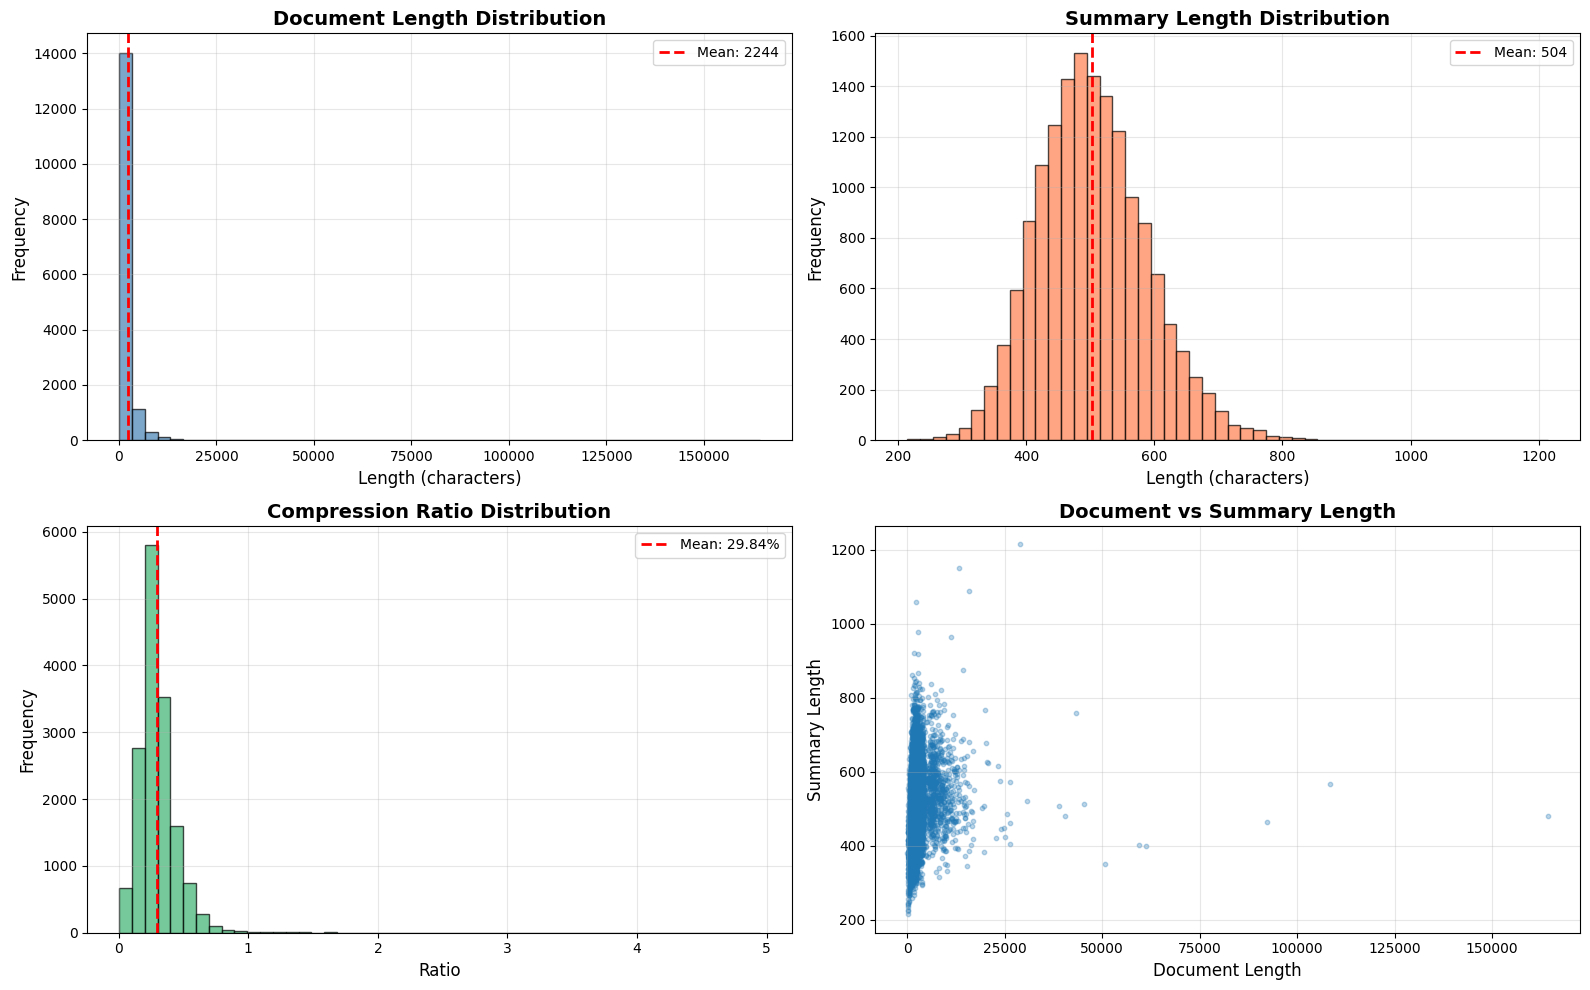

In [25]:
import matplotlib.pyplot as plt

# 1. First, recreate the length metrics using the correct column names
train_df['document_len'] = train_df['document'].str.len()
train_df['summary_len'] = train_df['summary'].str.len()
train_df['compression_ratio'] = train_df['summary_len'] / train_df['document_len']

# 2. Visualize data distribution
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Document length distribution (Changed from article_len)
axes[0,0].hist(train_df['document_len'], bins=50, color='steelblue', alpha=0.7, edgecolor='black')
axes[0,0].axvline(train_df['document_len'].mean(), color='red', linestyle='--', linewidth=2, 
                 label=f'Mean: {train_df["document_len"].mean():.0f}')
axes[0,0].set_xlabel('Length (characters)', fontsize=12)
axes[0,0].set_ylabel('Frequency', fontsize=12)
axes[0,0].set_title('Document Length Distribution', fontsize=14, fontweight='bold')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# Summary length distribution
axes[0,1].hist(train_df['summary_len'], bins=50, color='coral', alpha=0.7, edgecolor='black')
axes[0,1].axvline(train_df['summary_len'].mean(), color='red', linestyle='--', linewidth=2, 
                 label=f'Mean: {train_df["summary_len"].mean():.0f}')
axes[0,1].set_xlabel('Length (characters)', fontsize=12)
axes[0,1].set_ylabel('Frequency', fontsize=12)
axes[0,1].set_title('Summary Length Distribution', fontsize=14, fontweight='bold')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# Compression ratio
axes[1,0].hist(train_df['compression_ratio'], bins=50, color='mediumseagreen', alpha=0.7, edgecolor='black')
axes[1,0].axvline(train_df['compression_ratio'].mean(), color='red', linestyle='--', linewidth=2, 
                 label=f'Mean: {train_df["compression_ratio"].mean():.2%}')
axes[1,0].set_xlabel('Ratio', fontsize=12)
axes[1,0].set_ylabel('Frequency', fontsize=12)
axes[1,0].set_title('Compression Ratio Distribution', fontsize=14, fontweight='bold')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# Scatter plot (Changed from article_len to document_len)
axes[1,1].scatter(train_df['document_len'], train_df['summary_len'], alpha=0.3, s=10)
axes[1,1].set_xlabel('Document Length', fontsize=12)
axes[1,1].set_ylabel('Summary Length', fontsize=12)
axes[1,1].set_title('Document vs Summary Length', fontsize=14, fontweight='bold')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('data_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

## 4️⃣ DATA PREPROCESSING

In [26]:
def clean_text(text):
    """Clean Vietnamese text"""
    if not isinstance(text, str):
        return ""
    
    # Remove extra whitespace
    text = ' '.join(text.split())
    text = text.strip()
    
    return text

# Clean data - Using 'document' column name from new dataset
print("Cleaning data...")
train_df['document'] = train_df['document'].apply(clean_text)
train_df['summary'] = train_df['summary'].apply(clean_text)

# Remove invalid samples
original_len = len(train_df)
train_df = train_df[train_df['document'].str.len() > 50]
train_df = train_df[train_df['summary'].str.len() > 10]
train_df = train_df[train_df['document'].str.len() < 10000]  # Increased from 5000 for longer documents

print(f"✅ Clean dataset: {len(train_df):,} samples")
print(f"✅ Removed {original_len - len(train_df):,} invalid samples")

# Display sample
print(f"\n📝 Sample after cleaning:")
print(f"Document (first 200 chars): {train_df.iloc[0]['document'][:200]}...")
print(f"Summary: {train_df.iloc[0]['summary'][:150]}...")

Cleaning data...
✅ Clean dataset: 15,441 samples
✅ Removed 179 invalid samples

📝 Sample after cleaning:
Document (first 200 chars): Lá N của cây N lô hội N chứa V đầy A chất N gel N và bạn N có thể hái V mỗi khi N cần V . Nên V để khi N nào dùng V mới hái V . Cắt N một nhánh N từ cây lô hội N và vắt V hoặc múc V phần N gel V trong...
Summary: Lô hội, với chất gel giàu dưỡng chất, có thể sử dụng để chữa lành các vấn đề về da như bỏng nắng, gàu và da khô. Bạn có thể sử dụng lá lô hội tươi để ...


In [27]:
# ============================================================================
# Use Pre-loaded Train/Val/Test Splits
# ============================================================================
print("Setting up dataset splits...")

# The data is already split into train/validation/test from Kaggle input
# Just assign them to the variables we'll use
train = train_df.reset_index(drop=True)
val = val_df.reset_index(drop=True)
test = test_df.reset_index(drop=True)

print(f"\n✅ Dataset splits ready:")
print(f"{'='*80}")
total_samples = len(train) + len(val) + len(test)
print(f"  Train:      {len(train):>6,} samples ({len(train)/total_samples:>6.1%})")
print(f"  Validation: {len(val):>6,} samples ({len(val)/total_samples:>6.1%})")
print(f"  Test:       {len(test):>6,} samples ({len(test)/total_samples:>6.1%})")
print(f"  {'─'*76}")
print(f"  Total:      {total_samples:>6,} samples (100.0%)")
print(f"{'='*80}")

# Verify columns exist
print(f"\n🔍 Verifying data structure:")
required_cols = ['document', 'summary']
for split_name, split_df in [('Train', train), ('Validation', val), ('Test', test)]:
    missing_cols = [col for col in required_cols if col not in split_df.columns]
    if missing_cols:
        print(f"  ❌ {split_name}: Missing columns {missing_cols}")
    else:
        print(f"  ✅ {split_name}: All required columns present")

print(f"\n📋 Available columns: {train.columns.tolist()}")

Setting up dataset splits...

✅ Dataset splits ready:
  Train:      15,441 samples ( 79.8%)
  Validation:  1,952 samples ( 10.1%)
  Test:        1,953 samples ( 10.1%)
  ────────────────────────────────────────────────────────────────────────────
  Total:      19,346 samples (100.0%)

🔍 Verifying data structure:
  ✅ Train: All required columns present
  ✅ Validation: All required columns present
  ✅ Test: All required columns present

📋 Available columns: ['document', 'summary', 'keywords', 'document_len', 'summary_len', 'compression_ratio']


## 5️⃣ DATASET & DATALOADER

In [28]:
from torch.utils.data import Dataset

class SummarizationDataset(Dataset):
    """Dataset for text summarization
    
    Args:
        documents: Series or list of documents (changed from 'articles')
        summaries: Series or list of summaries
        tokenizer: Hugging Face tokenizer
        max_length: Max length for input documents
        max_target_length: Max length for target summaries
    """
    
    def __init__(self, documents, summaries, tokenizer, max_length=512, max_target_length=128):
        self.documents = documents  # Changed from 'articles' to 'documents'
        self.summaries = summaries
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.max_target_length = max_target_length
    
    def __len__(self):
        return len(self.documents)
    
    def __getitem__(self, idx):
        # Get document and summary
        document = "summarize: " + str(self.documents.iloc[idx])
        summary = str(self.summaries.iloc[idx])
        
        # Tokenize input
        inputs = self.tokenizer(
            document,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        
        # Tokenize target
        targets = self.tokenizer(
            summary,
            max_length=self.max_target_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        
        return {
            'input_ids': inputs['input_ids'].squeeze(),
            'attention_mask': inputs['attention_mask'].squeeze(),
            'labels': targets['input_ids'].squeeze()
        }

print("✅ Dataset class defined")
print("Note: Using 'document' column instead of 'article' to match new dataset format")

✅ Dataset class defined
Note: Using 'document' column instead of 'article' to match new dataset format


## 6️⃣ MODEL TRAINING - ViT5

### ViT5: Vietnamese T5

**ViT5 là model T5 được VietAI pre-train trên corpus tiếng Việt lớn:**
- 12 layers encoder + 12 layers decoder
- 768 hidden dimensions
- Optimized cho tiếng Việt
- Performance tốt hơn mT5 cho Vietnamese tasks

In [29]:
# Configuration
MODEL_NAME = 'VietAI/vit5-base'
BATCH_SIZE = 4  # Giảm nếu out of memory
LEARNING_RATE = 5e-5
NUM_EPOCHS = 3
MAX_LENGTH = 512
MAX_TARGET_LENGTH = 128

print(f"Model: {MODEL_NAME}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Learning rate: {LEARNING_RATE}")
print(f"Epochs: {NUM_EPOCHS}")

Model: VietAI/vit5-base
Batch size: 4
Learning rate: 5e-05
Epochs: 3


In [30]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

# Load model và tokenizer
print("Loading ViT5 model...")
print(f"Model: {MODEL_NAME}")

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSeq2SeqLM.from_pretrained(MODEL_NAME)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

print(f"\n✅ Model loaded successfully!")
print(f"  Device: {device}")
print(f"  Model parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"  Memory allocated: {torch.cuda.memory_allocated()/1024**3:.2f} GB" if torch.cuda.is_available() else "")

Loading ViT5 model...
Model: VietAI/vit5-base

✅ Model loaded successfully!
  Device: cpu
  Model parameters: 225,950,976



In [31]:
# Create datasets using the new 'document' column
print("Creating PyTorch datasets...")

train_dataset = SummarizationDataset(
    train['document'],  # Changed from 'article' to 'document'
    train['summary'],
    tokenizer,
    max_length=MAX_LENGTH,
    max_target_length=MAX_TARGET_LENGTH
)

val_dataset = SummarizationDataset(
    val['document'],  # Changed from 'article' to 'document'
    val['summary'],
    tokenizer,
    max_length=MAX_LENGTH,
    max_target_length=MAX_TARGET_LENGTH
)

print(f"\n✅ Datasets created:")
print(f"  Train dataset: {len(train_dataset):,} samples")
print(f"  Val dataset: {len(val_dataset):,} samples")
print(f"\n📝 Sample from train dataset:")
sample = train_dataset[0]
print(f"  input_ids shape: {sample['input_ids'].shape}")
print(f"  attention_mask shape: {sample['attention_mask'].shape}")
print(f"  labels shape: {sample['labels'].shape}")

Creating PyTorch datasets...

✅ Datasets created:
  Train dataset: 15,441 samples
  Val dataset: 1,952 samples

📝 Sample from train dataset:
  input_ids shape: torch.Size([512])
  attention_mask shape: torch.Size([512])
  labels shape: torch.Size([128])


In [32]:
from transformers import DataCollatorForSeq2Seq

# Data collator for dynamic padding
data_collator = DataCollatorForSeq2Seq(
    tokenizer,
    model=model,
    padding=True
)

print("✅ Data collator created")
print("  This will handle dynamic padding during training")

✅ Data collator created
  This will handle dynamic padding during training


In [33]:
import numpy as np
import evaluate

# Load ROUGE metric
print("Loading ROUGE metric...")
rouge_metric = evaluate.load('rouge')

def compute_metrics(eval_pred):
    """
    Compute ROUGE scores for evaluation
    
    Args:
        eval_pred: Tuple of (predictions, labels)
    
    Returns:
        dict: Dictionary with ROUGE-1, ROUGE-2, and ROUGE-L scores
    """
    predictions, labels = eval_pred
    
    # Decode predictions
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    
    # Replace -100 in labels (used for padding)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    
    # Compute ROUGE scores
    result = rouge_metric.compute(
        predictions=decoded_preds,
        references=decoded_labels,
        use_stemmer=True
    )
    
    # Return scores as percentages
    return {
        'rouge1': round(result['rouge1'] * 100, 2),
        'rouge2': round(result['rouge2'] * 100, 2),
        'rougeL': round(result['rougeL'] * 100, 2)
    }

print("✅ Metric function defined")
print("  Will compute ROUGE-1, ROUGE-2, and ROUGE-L scores")

Loading ROUGE metric...
✅ Metric function defined
  Will compute ROUGE-1, ROUGE-2, and ROUGE-L scores


In [ ]:
from transformers import Seq2SeqTrainingArguments
import torch

# ============================================================================
# Training Arguments - Compatible with transformers >= 4.50.0
# ============================================================================
# IMPORTANT: Parameter names changed in transformers 4.50+
# - evaluation_strategy -> eval_strategy
# ============================================================================

training_args = Seq2SeqTrainingArguments(
    # Output directory
    output_dir="/kaggle/working/vit5_summarization",
    overwrite_output_dir=True,

    # Evaluation & Saving - UPDATED PARAMETER NAMES
    eval_strategy="steps",  # ✅ Changed from 'evaluation_strategy'
    eval_steps=500,
    save_strategy="steps",
    save_steps=500,
    save_total_limit=3,

    # Model selection
    load_best_model_at_end=True,
    metric_for_best_model="rouge1",
    greater_is_better=True,

    # Training hyperparameters
    learning_rate=LEARNING_RATE,
    num_train_epochs=NUM_EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,

    # Optimization
    gradient_accumulation_steps=2,
    warmup_steps=500,
    weight_decay=0.01,

    # Performance
    fp16=torch.cuda.is_available(),  # Enable mixed precision on GPU
    dataloader_num_workers=2,

    # Logging
    logging_dir="/kaggle/working/logs",
    logging_steps=100,
    report_to="none",  # Change to 'tensorboard' if you want logging

    # Generation settings (for evaluation)
    predict_with_generate=True,
    generation_max_length=MAX_TARGET_LENGTH,
    generation_num_beams=4,

    # Reproducibility
    seed=42,
)

print("✅ Training arguments configured")
print(f"\n{'='*80}")
print("📋 TRAINING CONFIGURATION")
print(f"{'='*80}")
print(f"  Model: {MODEL_NAME}")
print(f"  Output dir: {training_args.output_dir}")
print(f"  {'─'*76}")
print(f"  Batch size (per device): {training_args.per_device_train_batch_size}")
print(f"  Gradient accumulation: {training_args.gradient_accumulation_steps}")
print(f"  Effective batch size: {training_args.per_device_train_batch_size * training_args.gradient_accumulation_steps}")
print(f"  {'─'*76}")
print(f"  Learning rate: {training_args.learning_rate}")
print(f"  Epochs: {training_args.num_train_epochs}")
print(f"  Warmup steps: {training_args.warmup_steps}")
print(f"  Weight decay: {training_args.weight_decay}")
print(f"  {'─'*76}")
print(f"  FP16 (mixed precision): {training_args.fp16}")
print(f"  Eval strategy: {training_args.eval_strategy}")
print(f"  Eval steps: {training_args.eval_steps}")
print(f"  Save steps: {training_args.save_steps}")
print(f"  {'─'*76}")
print(f"  Generation max length: {training_args.generation_max_length}")
print(f"  Generation num beams: {training_args.generation_num_beams}")
print(f"{'='*80}")

In [ ]:
from transformers import Seq2SeqTrainingArguments
import torch
from transformers import TrainingArguments

training_args = Seq2SeqTrainingArguments(
    output_dir="/kaggle/working/vit5_summarization",
    overwrite_output_dir=True,

    evaluation_strategy="steps",
    eval_steps=500,
    save_strategy="steps",
    save_steps=500,
    save_total_limit=3,

    load_best_model_at_end=True,
    metric_for_best_model="rouge1",
    greater_is_better=True,

    learning_rate=LEARNING_RATE,
    num_train_epochs=NUM_EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,

    gradient_accumulation_steps=2,
    warmup_steps=500,
    weight_decay=0.01,

    fp16=torch.cuda.is_available(),

    logging_steps=100,
    report_to="none",

    predict_with_generate=True,
    generation_max_length=MAX_TARGET_LENGTH,
    generation_num_beams=4,

    seed=42,
)


In [ ]:
# Start training
print("\n" + "="*60)
print("TRAINING ViT5 MODEL")
print("="*60 + "\n")

train_result = trainer.train()

print("\n✅ Training completed!")
print(f"Final training loss: {train_result.metrics['train_loss']:.4f}")

In [ ]:
# Save model
trainer.save_model('./vit5_final')
tokenizer.save_pretrained('./vit5_final')

print("✓ Model saved to ./vit5_final")

## 7️⃣ EVALUATION

In [ ]:
from tqdm.auto import tqdm

# Evaluate on test set
print("\n" + "="*80)
print("EVALUATING ON TEST SET")
print("="*80 + "\n")

model.eval()

results = {
    'rouge1': [],
    'rouge2': [],
    'rougeL': [],
    'predictions': [],
    'references': []
}

print(f"Generating predictions for {len(test):,} test samples...")

with torch.no_grad():
    for idx in tqdm(range(len(test)), desc="Evaluating"):
        # Get document and reference summary - using 'document' instead of 'article'
        document = "summarize: " + str(test.iloc[idx]['document'])
        reference = str(test.iloc[idx]['summary'])
        
        # Tokenize and generate
        inputs = tokenizer(
            document,
            max_length=MAX_LENGTH,
            truncation=True,
            return_tensors='pt'
        ).to(device)
        
        outputs = model.generate(
            **inputs,
            max_length=MAX_TARGET_LENGTH,
            num_beams=4,
            length_penalty=0.6,
            early_stopping=True,
            no_repeat_ngram_size=3
        )
        
        prediction = tokenizer.decode(outputs[0], skip_special_tokens=True)
        
        # Compute ROUGE using the metric
        scores = rouge_metric.compute(
            predictions=[prediction],
            references=[reference],
            use_stemmer=True
        )
        
        results['rouge1'].append(scores['rouge1'])
        results['rouge2'].append(scores['rouge2'])
        results['rougeL'].append(scores['rougeL'])
        results['predictions'].append(prediction)
        results['references'].append(reference)

# Print final results
print(f"\n{'='*80}")
print("📊 TEST RESULTS")
print(f"{'='*80}")
print(f"\nROUGE-1: {np.mean(results['rouge1'])*100:.2f} ± {np.std(results['rouge1'])*100:.2f}")
print(f"ROUGE-2: {np.mean(results['rouge2'])*100:.2f} ± {np.std(results['rouge2'])*100:.2f}")
print(f"ROUGE-L: {np.mean(results['rougeL'])*100:.2f} ± {np.std(results['rougeL'])*100:.2f}")
print(f"{'='*80}\n")

## 8️⃣ ANALYSIS & VISUALIZATION

In [ ]:
# Plot ROUGE distribution
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

scores = ['rouge1', 'rouge2', 'rougeL']
titles = ['ROUGE-1', 'ROUGE-2', 'ROUGE-L']
colors = ['steelblue', 'coral', 'mediumseagreen']

for idx, (score, title, color) in enumerate(zip(scores, titles, colors)):
    axes[idx].hist(results[score], bins=30, alpha=0.7, color=color, edgecolor='black')
    axes[idx].axvline(np.mean(results[score]), color='red', linestyle='--', 
                    linewidth=2, label=f'Mean: {np.mean(results[score]):.3f}')
    axes[idx].set_xlabel('Score', fontsize=12)
    axes[idx].set_ylabel('Frequency', fontsize=12)
    axes[idx].set_title(f'{title} Distribution', fontsize=14, fontweight='bold')
    axes[idx].legend(fontsize=11)
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('rouge_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Sample predictions
print("\n" + "="*80)
print("SAMPLE PREDICTIONS")
print("="*80 + "\n")

n_samples = 5
indices = np.random.choice(len(results['predictions']), n_samples, replace=False)

for i, idx in enumerate(indices):
    print(f"\n{'─'*80}")
    print(f"Sample {i+1}")
    print(f"{'─'*80}")
    print(f"\n📝 Reference:")
    print(f"{results['references'][idx]}")
    print(f"\n🤖 Generated:")
    print(f"{results['predictions'][idx]}")
    print(f"\n📊 Scores:")
    print(f"ROUGE-1: {results['rouge1'][idx]:.3f} | "
          f"ROUGE-2: {results['rouge2'][idx]:.3f} | "
          f"ROUGE-L: {results['rougeL'][idx]:.3f}")

## 9️⃣ SAVE RESULTS

In [ ]:
# Save detailed results
results_df = pd.DataFrame({
    'reference': results['references'],
    'prediction': results['predictions'],
    'rouge1': results['rouge1'],
    'rouge2': results['rouge2'],
    'rougeL': results['rougeL']
})

results_df.to_csv('test_results.csv', index=False)
print("✓ Results saved to test_results.csv")

# Save summary statistics
summary = {
    'model': MODEL_NAME,
    'rouge1_mean': float(np.mean(results['rouge1'])),
    'rouge1_std': float(np.std(results['rouge1'])),
    'rouge2_mean': float(np.mean(results['rouge2'])),
    'rouge2_std': float(np.std(results['rouge2'])),
    'rougeL_mean': float(np.mean(results['rougeL'])),
    'rougeL_std': float(np.std(results['rougeL'])),
    'test_samples': len(test)
}

with open('summary_statistics.json', 'w', encoding='utf-8') as f:
    json.dump(summary, f, indent=2, ensure_ascii=False)

print("✓ Summary saved to summary_statistics.json")

print("\n✅ ALL DONE!")